# Contacts vs distance

Welcome to the cooltools expected & contacts-vs-distance notebook!

Hi-C contact maps contain a variety of patterns-- that's why they are sometimes difficult to analyse :).

The strongest signal in a typical Hi-C map is the decay of contact frequency with **genomic separation** (also referred to as **genomic distance**). In the Hi-C field, this decay is often interchangeably referred to as the: 

* **expected** because one "expects" a certain average contact frequency at a given genomic separation
* **scaling** which is borrowed from the polymer physics literature
* **P(s) curve** contact *probability*, *P*, as a function of genomic *separation*, *s*. 

The monotonic decay of contacts with genomic separation is reflective of the polymeric nature of chromosomes and can tell us about the global folding patterns of the genome. 

This decay has been observed to vary through the cell cycle, across cell types, and after degredation of structural maintenance of chromosomes complexes (SMCs) in both interphase and mitosis. 

The goals of this notebook are to:

* calculate the P(s) of a given cooler
* plot the P(s) curve
* smooth the P(s) curve with logarithmic binning
* plot the derivative of P(s)
* plot the P(s) between two different genomic regions
* plot the matrix of average contact frequencies between different chromosomes

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import core packages
import warnings
warnings.filterwarnings("ignore")
from itertools import combinations

# import semi-core packages
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline
plt.style.use('seaborn-poster')
import numpy as np
import pandas as pd

# import open2c libraries
import bioframe

import cooler
import cooltools
import cooltools.expected

In [3]:
# download test data
# this file is 145 Mb, and may take a few seconds to download
cool_file = cooltools.download_data("HFF_MicroC", cache=True, data_dir='./')    
print(cool_file)

./test.mcool


In [4]:
# Load a Hi-C map at a 1kb resolution from a cooler file.
clr = cooler.Cooler('./test.mcool::/resolutions/1000')

In addition to data stored in a cooler, the analyses below make use
of where chromosomal arms start and stop to calculate contact frequency versus distance curves
within arms. For commonly-used genomes, bioframe can be used to fetch these 
annotations directly from UCSC. For less commonly-used genomes, a table of arms, or chromosomes 
can be loaded in directly with pandas, e.g.  

`chromsizes = pd.read_csv('chrom.sizes', sep='\t')`

Regions for calculating expected should be provided as a [viewFrame](https://bioframe.readthedocs.io/en/latest/guide-intervalops.html#genomic-views), i.e. a dataframe with four columns, chrom, start, stop, name,
where entries in the name column are unique and the intervals are non-overlapping. If the chromsizes table does not have a name column, it can be created with  `bioframe.core.construction.add_ucsc_name_column(bioframe.make_viewframe(chromsizes))`.

In [5]:
# Use bioframe to fetch the genomic features from the UCSC.
hg38_chromsizes = bioframe.fetch_chromsizes('hg38')
hg38_cens = bioframe.fetch_centromeres('hg38')
hg38_arms = bioframe.core.construction.add_ucsc_name_column(bioframe.make_chromarms(hg38_chromsizes,  hg38_cens))

hg38_arms = hg38_arms[hg38_arms.chrom.isin(clr.chromnames)].reset_index(drop=True)
hg38_arms

,chrom,start,end,name
0,chr2,0,93139351,chr2:0-93139351
1,chr2,93139351,242193529,chr2:93139351-242193529
2,chr17,0,24714921,chr17:0-24714921
3,chr17,24714921,83257441,chr17:24714921-83257441


### Calculate the P(s) curve

To calculate the average contact frequency as a function of genomic separation, we will rely on the fact that each diagonal of a Hi-C map records contacts between loci separated by the same genomic distance. For example, the 3rd diagonal of our matrix contains contacts between loci separated by 3-4kb (note that diagonals are 0-indexed). Thus, we calculate the average contact frequency, *P(s)*, at a given genomic distance, *s*, as the average value of all pixels of the corresponding diagonal. This operation is performed by `cooltools.expected.get_cis_expected`.

Note that we calculate the *P(s)* separately for each chromosomal **arm**. This way we will ignore contacts accross the centromere, which is generally a good idea, since such contacts have a slightly different decay versus genomic separation.

In [6]:
# cvd == contacts-vs-distance
cvd = cooltools.expected.get_cis_expected(
    clr=clr,
    view_df=hg38_arms,
)

This function calculates the sum of raw and normalized interaction counts (`count.sum` and `balanced.sum`) for each diagonal of a Hi-C map.
It also provides the number of valid (i.e. non-masked) pixels at each diagonal, `n_valid`, so that we can calculate the average contact frequency later.

In [7]:
display(cvd.head(4))
display(cvd.tail(4))

,region1,region2,dist,n_valid,count.sum,balanced.sum,count.avg,balanced.avg
0,chr2:0-93139351,chr2:0-93139351,0,86055,NaN,NaN,NaN,NaN
1,chr2:0-93139351,chr2:0-93139351,1,85282,NaN,NaN,NaN,NaN
2,chr2:0-93139351,chr2:0-93139351,2,84918,10842540.0,8344.916674,127.682470,0.098270
3,chr2:0-93139351,chr2:0-93139351,3,84649,4733321.0,3623.417357,55.917034,0.042805


,region1,region2,dist,n_valid,count.sum,balanced.sum,count.avg,balanced.avg
325450,chr17:24714921-83257441,chr17:24714921-83257441,58540,0,0.0,0.0,NaN,NaN
325451,chr17:24714921-83257441,chr17:24714921-83257441,58541,0,0.0,0.0,NaN,NaN
325452,chr17:24714921-83257441,chr17:24714921-83257441,58542,0,0.0,0.0,NaN,NaN
325453,chr17:24714921-83257441,chr17:24714921-83257441,58543,0,0.0,0.0,NaN,NaN


Note that the data from first couple of diagonals are masked. This is done intentionally, since interactions at these diagonals (very short-ranged) are contaminated by non-informative Hi-C byproducts - dangling ends and self-circles. 

Note this treats each genomic region separately and does not aggregate the results automatically. This reflects the overall philosophy of cooltools, according to which we strive to provide access to data at different levels of aggregation. For example, with the python API, a user can easily to check if *P(s)* differs between regions. 

In this notebook, however, we focus on the genome-average *P(s)*, so we aggregate results from different regions together. This can be done via the pandas groupby functionality:

In [8]:
# Aggregate diagonals from different genomic regions together. 
# Since all three calcuated statistics are additive, they can be aggregated
# easily via sum() functiond.
cvd_agg = (
    cvd
    .groupby('dist')
    .agg(
        {'n_valid':'sum',
         'count.sum':'sum',
         'balanced.sum':'sum',
        })
    .reset_index()
)

# Convert indices of diagonals into genomic separation, expressed in basepairs.
cvd_agg['s_bp'] = (
    cvd_agg['dist'] 
    * clr.binsize)

# Now we can calculate the average raw interaction counts and normalized contact frequencies.
cvd_agg['count.avg'] = (
    cvd_agg['count.sum']
    / cvd_agg['n_valid']
)

cvd_agg['balanced.avg'] = (
    cvd_agg['balanced.sum']
    / cvd_agg['n_valid']
)

### Plot the P(s) curve

Time to plot *P(s)* !

The challenge here is that Hi-C has a uniquely wide dynamic range. Hi-C probes genomic separations ranging from 100s to 100,000,000s of basepairs and contact frequencies also tend to span many orders of magnitude.

Plotting such data in the linear scale would reveal only a part of the whole picture. Instead, we typically switch to double logarithmic (aka log-log) plots, where the x and y coordinates vary by orders of magnitude.

In [9]:
cvd_agg.loc[0:1, :] = np.nan; #since pandas groupby replaces nan with zero

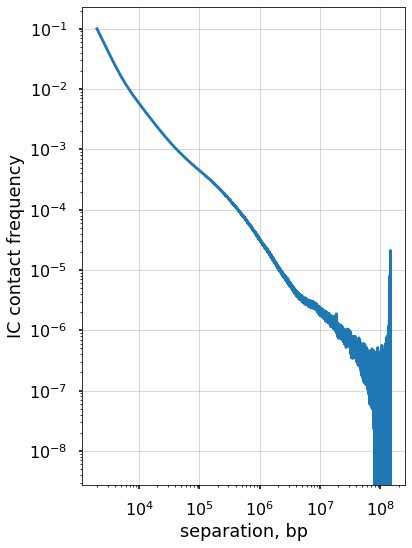

In [10]:
f, ax = plt.subplots(1,1)
ax.loglog(
    cvd_agg['s_bp'],
    cvd_agg['balanced.avg'],
)
ax.set(
    xlabel='separation, bp', 
    ylabel='IC contact frequency')
ax.set_aspect(1.0)
ax.grid(lw=0.5)

With this data, we also have an opportunity to test the effect of matrix balancing on the P(s) curve. 

Raw and balanced Hi-C data have different units, counts for raw data vs. frequencies-that-sum-to-1.0 for balanced data. To plot the two curves on the same canvas, we have to normalize them to the same scale. Generally, there is no "best" way to normalize P(s) curves, and different approaches rely on different assumptions. 

The simplest assumption we can make is that our two P(s) curves match at short genomic separations. With this assumption, the shape of P(s) curves is almost unaffected by balancing.

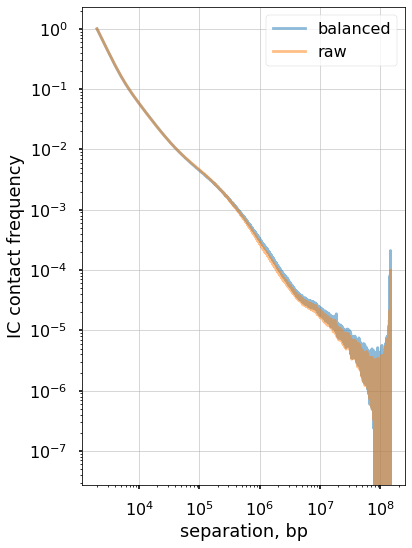

In [11]:
f, ax = plt.subplots(1,1)
# Below we normalize both P(s) curves by their first non-zero value 
# (remember that we mask the first 2 diagonals).
ax.loglog(
    cvd_agg['s_bp'],
    cvd_agg['balanced.avg'] / cvd_agg['balanced.avg'].iloc[2],
    alpha=0.5,
    label='balanced'
)
ax.loglog(
    cvd_agg['s_bp'],
    cvd_agg['count.avg'] / cvd_agg['count.avg'].iloc[2],
    alpha=0.5,
    label='raw'
)

ax.set(
    xlabel='separation, bp', 
    ylabel='IC contact frequency')
ax.set_aspect(1.0)
ax.grid(lw=0.5)
_=ax.legend()

### Smooth the P(s) curve with logarithmic binning.

The curves plotted above form characteristic "fans" at longer separations. This happens for two reasons: (a) we plot values of **each** diagonal separately and thus each decade of s contains 10x more points, and (b) due to the polymer nature of chromosomes, contacts at longer separations are weaker and thus more affected by counting noise.  

This issue is more that just cosmetic, as this noise would prevent us from doing finer analyses of *P(s)* and propagate into data derived from *P(s)*. However, there is a simple solution: we can calculate *P(s)* not for individual diagonals, but rather for whole groups of consecutive diagonals (a.k.a. genomic distance bins). This works because *P(s)* changes very gradually with *s*, so that consecutive diagonals have similar values. Furthermore, we can make each subsequent distance bin wider than the previous one, so that each order of magnitude of genomic separation contains the same number of bins. Such aggregation requires multiple steps, but `cooltools.expected` provides this function out of the box.

In [12]:
# Logbin-expected aggregates P(s) curves per region over exponentially increasing distance bins.
lb_cvd, lb_slopes, lb_distbins = cooltools.expected.logbin_expected(cvd)

# The resulting table contains P(s) curves for each individual region.
# Cooltools has another function to aggregate these curves into a single genome-wide curve.
lb_cvd_agg, lb_slopes_agg = cooltools.expected.combine_binned_expected(
    lb_cvd,
    binned_exp_slope=lb_slopes
)

lb_cvd_agg['s_bp'] = lb_cvd_agg['dist.avg'] * clr.binsize 
lb_slopes_agg['s_bp'] = lb_slopes_agg['dist.avg'] * clr.binsize 

### Plot the smoothed P(s) curve and its derivative

Logbin-smoothing of P(s) reduces the "fanning" at longer s and enables us to plot the derivative of the P(s) curve in the log-log space. This derivative is extremely informative, as it can be compared to predictions from various polymer models.

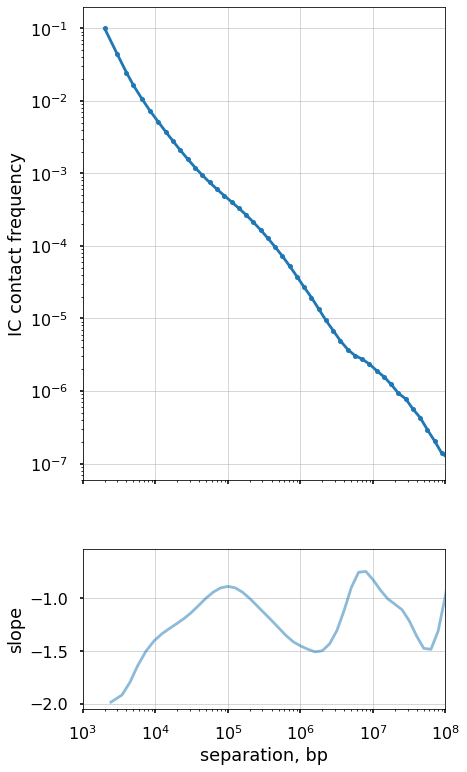

In [13]:
f, axs = plt.subplots(
    figsize=(6.5,13),
    nrows=2, 
    gridspec_kw={'height_ratios':[6,2]}, 
    sharex=True)
ax = axs[0]
ax.loglog(
    lb_cvd_agg['s_bp'],
    lb_cvd_agg['balanced.avg'],
    'o-',
    markersize=5,
)

ax.set(
    ylabel='IC contact frequency',
    xlim=(1e3,1e8)
)
ax.set_aspect(1.0)
ax.grid(lw=0.5)


ax = axs[1]
ax.semilogx(
    lb_slopes_agg['s_bp'],
    lb_slopes_agg['slope'],
    alpha=0.5
)

ax.set(
    xlabel='separation, bp', 
    ylabel='slope')

ax.grid(lw=0.5)

### Plot the P(s) curve for interactions between different regions.

Finally, we can plot P(s) curves for contacts between loci that belong to different regions. 

A commonly considered situation is for trans-arm interactions, i.e. contacts between loci on the opposite side of a centromere. Such P(s) can be calculated via `cooltools.expected.get_cis_expected` by passing `intra_only=False`.

In [15]:
# cvd_inter == contacts-vs-distance between chromosomal arms
cvd_inter = cooltools.expected.get_cis_expected(
    clr=clr,
    view_df=hg38_arms,
    intra_only=False,
)

In [16]:
# Logbin-expected aggregates P(s) curves per region over exponentially increasing distance bins.
cvd_inter['region'] = cvd_inter['region1'] + '&' + cvd_inter['region2']
lb_inter_cvd, lb_inter_slopes, lb_inter_distbins = cooltools.expected.logbin_expected(cvd_inter)

# The resulting table contains P(s) curves for each individual region.
lb_cvd_inter_agg, lb_inter_slopes_agg = cooltools.expected.combine_binned_expected(
    lb_inter_cvd,
    lb_inter_slopes
)

lb_cvd_inter_agg['s_bp'] = lb_cvd_inter_agg['dist.avg'] * clr.binsize 
lb_inter_slopes_agg['s_bp'] = lb_inter_slopes_agg['dist.avg'] * clr.binsize 


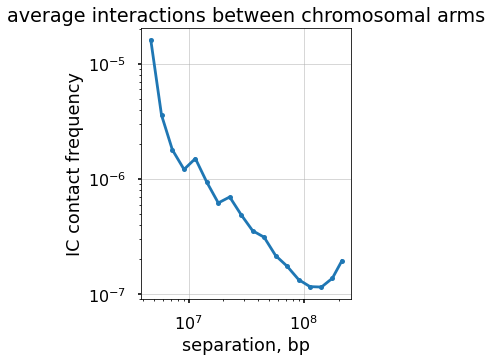

In [17]:
f, ax = plt.subplots(1,1,
    figsize=(5,5),)

ax.loglog(
    lb_cvd_inter_agg['s_bp'],
    lb_cvd_inter_agg['balanced.avg'],
    marker='o',
    markersize=5,
)


ax.set(
    xlabel='separation, bp', 
    ylabel='IC contact frequency',
    title="average interactions between chromosomal arms")
ax.grid(lw=0.5)
ax.set_aspect(1.0)


### Averaging interaction frequencies in blocks

For *trans* (i.e. inter-chromosomal) interactions, the notion of "genomic separation" becomes irrelevant, as loci on different chromosomes are not connected by any polymer chain. Thus, the "expected" level of trans interactions is a scalar, the average interaction frequency for a given pair of chromosomes.

In [18]:
# average contacts, in this case between pairs of chromosomal arms:
regions = hg38_arms.copy()

ac = cooltools.expected.get_trans_expected(
    clr,
    view_df = regions,
    nproc=8
)

# Now we can calculate the average raw interaction counts and normalized contact frequencies.
ac["balanced.avg"] = (
    ac["balanced.sum"]
    / ac["n_valid"]
)

In [19]:
# pivot a table to generate a pair-wise average interaction heatmap:
acp = (ac 
    .pivot_table(values="balanced.avg",
                 index="region1",
                 columns="region2",
                 observed=True) 
    .reindex(index=regions.name,
             columns=regions.name)
)

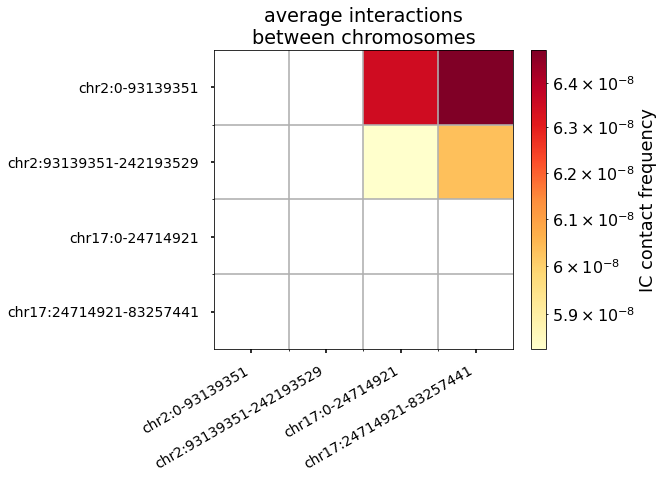

In [20]:
fs = 14

f, axs = plt.subplots(
    figsize=(6.0,5.5),
    ncols=2,
    gridspec_kw={'width_ratios':[20,1],"wspace":0.1},
)
# assign heatmap and colobar axis:
ax, cax = axs
# draw a heatmap, using log-scale for interaction freq-s:
acpm = ax.imshow(
    acp,
    cmap="YlOrRd",
    norm=colors.LogNorm(),
    aspect=1.0
)
# assign ticks and labels (ordered names of chromosome arms):
ax.set(
    xticks=range(len(regions)),
    yticks=range(len(regions)),
    title="average interactions\nbetween chromosomes",
)
ax.set_xticklabels(
    regions.name,
    rotation=30,
    horizontalalignment='right',
    fontsize=fs
)
ax.set_yticklabels(
    regions.name,
    fontsize=fs
)
# draw a colorbar of interaction frequencies for the heatmap:
f.colorbar(
    acpm,
    cax=cax,
    label='IC contact frequency'
)

# draw a grid around values:
ax.set_xticks(
    [x-0.5 for x in range(1,len(regions))],
    minor=True
)
ax.set_yticks(
    [y-0.5 for y in range(1,len(regions))],
    minor=True
)
ax.grid(which="minor")
